In [36]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
from matplotlib.lines import Line2D

In [9]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
    """

    def __init__(self, input_size, hidden_size, dt=None, alpha=0.1, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            self.alpha = alpha
        else:
            self.alpha = dt / self.tau
        self.oneminusalpha = 1 - self.alpha
        self._sigma_rec = np.sqrt(2 * self.alpha) * sigma_rec

        # Input to hidden linear transformation
        self.input2h = nn.Linear(input_size, hidden_size)
        # Hidden to hidden transformation
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input):
        # Initialize the hidden state
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)  # Single tensor for hidden state

    def recurrence(self, input, hidden):
        """Recurrence helper with a single hidden tensor."""
        # Recurrence with input and hidden state
        total_input = self.input2h(input) + self.h2h(hidden)
        state = hidden * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)  # Add noise to the state
        output = torch.relu(state)  # Apply ReLU activation
        return output

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        for i in range(input.size(0)):
            # Iteratively update hidden states based on inputs
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        output = torch.stack(output, dim=0)  # Stack outputs to form the final output
        return output, hidden

class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output


In [10]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [4]:
import neurogym as ngym

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment
task = 'SingleContextDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=5, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.3516
Step 400, Loss 0.2256
Step 600, Loss 0.1655
Step 800, Loss 0.1184
Step 1000, Loss 0.0912
Step 1200, Loss 0.0782
Step 1400, Loss 0.0684
Step 1600, Loss 0.0626
Step 1800, Loss 0.0581
Step 2000, Loss 0.0553
Step 2200, Loss 0.0528
Step 2400, Loss 0.0507
Step 2600, Loss 0.0495
Step 2800, Loss 0.0482
Step 3000, Loss 0.0477
Step 3200, Loss 0.0469
Step 3400, Loss 0.0465
Step 3600, Loss 0.0461
Step 3800, Loss 0.0455
Step 4000, Loss 0.0458
Step 4200, Loss 0.0450
Step 4400, Loss 0.0454
Step 4600, Loss 0.0438
Step 4800, Loss 0.0411
Step 5000, Loss 0.0408


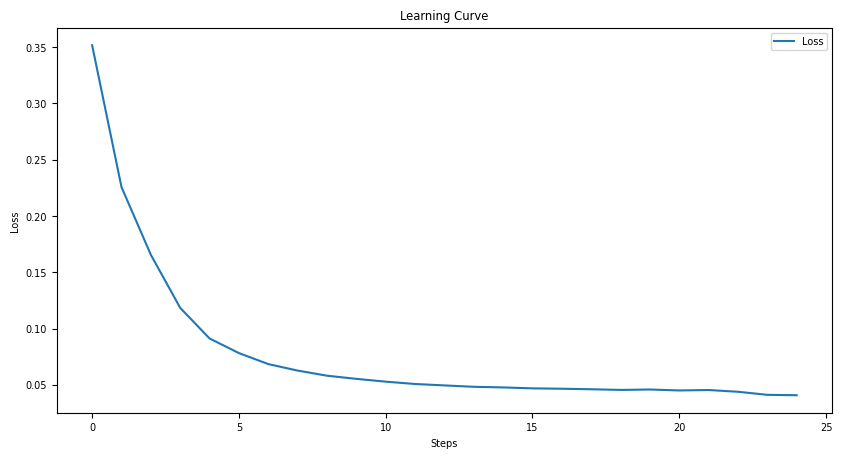

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [6]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average performance 0.806


Shape of the neural activity (Time points, Neurons): (48648, 50)
Shape of the projected activity (Time points, PCs): (48648, 2)


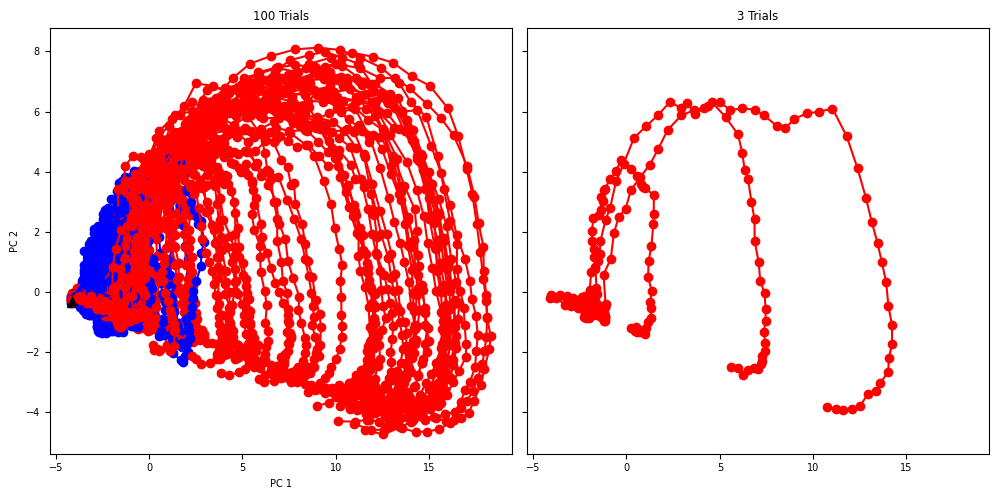

In [7]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()


In [20]:
import neurogym as ngym

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment
task = 'PerceptualDecisionMakingDelayResponse-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.5621
Step 400, Loss 0.3753
Step 600, Loss 0.3490
Step 800, Loss 0.3303
Step 1000, Loss 0.3278
Step 1200, Loss 0.3150
Step 1400, Loss 0.3008
Step 1600, Loss 0.2969
Step 1800, Loss 0.2928
Step 2000, Loss 0.2867
Step 2200, Loss 0.2873
Step 2400, Loss 0.2842
Step 2600, Loss 0.2855
Step 2800, Loss 0.2801
Step 3000, Loss 0.2870
Step 3200, Loss 0.2785
Step 3400, Loss 0.2800
Step 3600, Loss 0.2797
Step 3800, Loss 0.2774
Step 4000, Loss 0.2802
Step 4200, Loss 0.2799
Step 4400, Loss 0.2763
Step 4600, Loss 0.2780
Step 4800, Loss 0.2747
Step 5000, Loss 0.2762


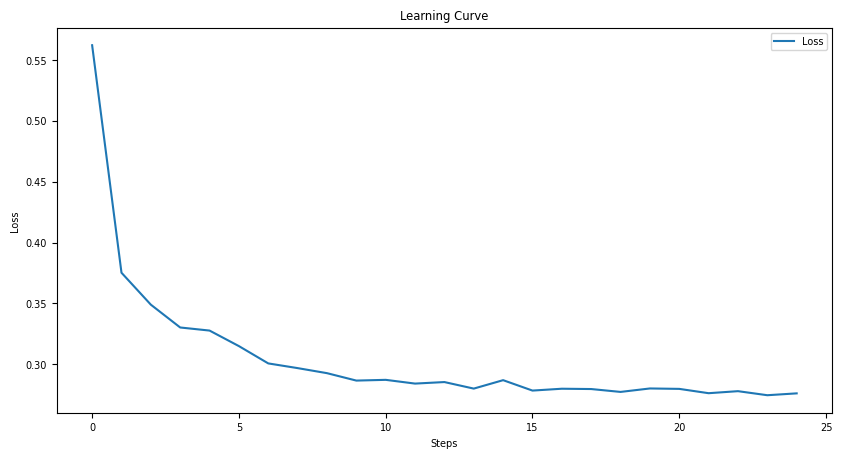

In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.506


Shape of the neural activity (Time points, Neurons): (100310, 50)
Shape of the projected activity (Time points, PCs): (100310, 2)


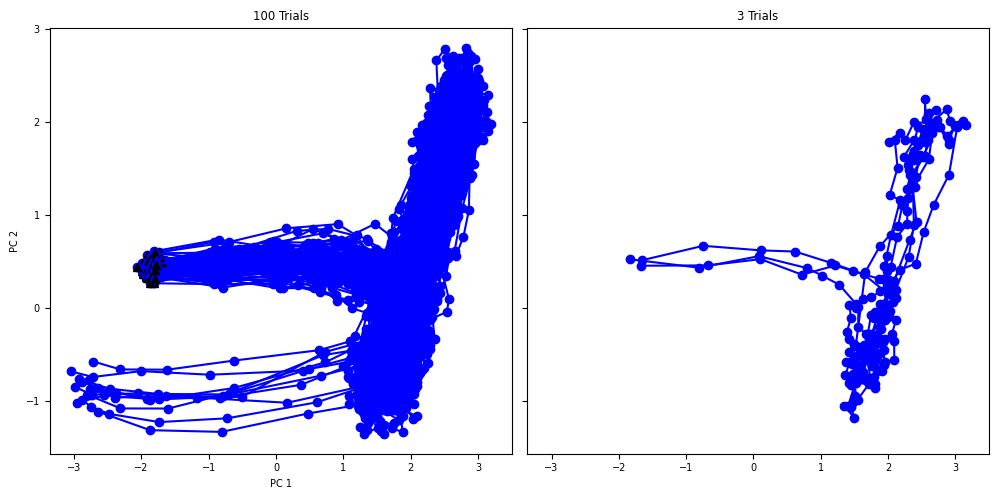

In [23]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

In [24]:

class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size_taskA, output_size_taskB, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc_taskA = nn.Linear(hidden_size, output_size_taskA)
        self.fc_taskB = nn.Linear(hidden_size, output_size_taskB)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out_taskA = self.fc_taskA(rnn_output)
        out_taskB = self.fc_taskB(rnn_output)
        return out_taskA, out_taskB, rnn_output

In [77]:
# @title importing neurogym
import neurogym as ngym

# Canned environment from neurogym

taskA_name = 'GoNogo-v0'
taskB_name = 'PerceptualDecisionMakingDelayResponse-v0'

# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

In [78]:
# Make supervised dataset
seq_len = 100
batch_size = 16
datasetA = ngym.Dataset(taskA_name, batch_size=batch_size, seq_len=seq_len)
datasetB = ngym.Dataset(taskB_name, batch_size=batch_size, seq_len=seq_len)
envA = datasetA.env
envB = datasetB.env

# Generate one batch of data when called
inputsA, target = datasetA()
inputsB, target = datasetB()

# Convert to PyTorch tensors
inputsA = torch.from_numpy(inputsA).type(torch.float)
inputsB = torch.from_numpy(inputsB).type(torch.float)

input_size = envA.observation_space.shape[0]
output_size_taskA = envA.action_space.n
output_size_taskB = envB.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([160, 1, 3])
Target has shape (SeqLen, Batch) = (100, 16)


In [79]:
import time
# Instantiate the network and print information
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size_taskA=output_size_taskA, output_size_taskB=output_size_taskB, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion_taskA = nn.CrossEntropyLoss()
    criterion_taskB = nn.CrossEntropyLoss()

    # Training loop

    running_loss = 0
    running_acc = 200
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(500):
        # Generate input and target, convert to pytorch tensor
        inputsA, labelsA = datasetA()
        inputsB, labelsB = datasetB()
        inputsA = torch.from_numpy(inputsA).type(torch.float)
        inputsB = torch.from_numpy(inputsB).type(torch.float)
        labelsA = torch.from_numpy(labelsA.flatten()).type(torch.long)
        labelsB = torch.from_numpy(labelsB.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output_taskA, output_taskB, _ = net(inputsA)
        output_taskA, output_taskB, _ = net(inputsB)
        # Reshape to (SeqLen x Batch, OutputSize)
        output_taskA = output_taskA.view(-1, output_size_taskA)
        output_taskB = output_taskB.view(-1, output_size_taskB)
        loss_taskA = criterion_taskA(output_taskA, labelsA)
        loss_taskB = criterion_taskB(output_taskB, labelsB)
        loss = loss_taskA + loss_taskB
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return net

net = train_model(net, dataset)

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_taskA): Linear(in_features=50, out_features=2, bias=True)
  (fc_taskB): Linear(in_features=50, out_features=3, bias=True)
)
Training network...
Step 100, Loss 1.2576, Time 5.7s
Step 200, Loss 0.9561, Time 12.5s
Step 300, Loss 0.8609, Time 18.3s
Step 400, Loss 0.8196, Time 25.0s
Step 500, Loss 0.7978, Time 31.0s


In [80]:
# Reset environment
envA = datasetA.env
envB = datasetB.env
envA.reset(no_step=True)
envB.reset(no_step=True)

# Initialize variables for logging
perf_taskA = 0
perf_taskB = 0
activity_dict_taskA = {}  # recording activity for Task A
activity_dict_taskB = {}  # recording activity for Task B
trial_infos_taskA = {}  # recording trial information for Task A
trial_infos_taskB = {}  # recording trial information for Task B

num_trial = 500
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info_A = envA.new_trial()
    # Observation and groud-truth of this trial
    ob_A, gt_A = envA.ob, envA.gt
    # Convert to numpy, add batch dimension to input
    inputs_A = torch.from_numpy(ob_A[:, np.newaxis, :]).type(torch.float)

    trial_info_B = envB.new_trial()
    ob_B, gt_B = envB.ob, envB.gt
    inputs_B = torch.from_numpy(ob_B[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred_taskA, action_pred_taskB, rnn_activity = net(inputs_A)

    # Compute performance
    # First convert back to numpy
    action_pred_taskA = action_pred_taskA.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice_A = np.argmax(action_pred_taskA[-1, :])
    # Compare to ground truth
    correct_A = choice_A == gt_A[-1]

    action_pred_taskB = action_pred_taskB.detach().numpy()[:, 0, :]
    choice_B = np.argmax(action_pred_taskB[-1, :])
    correct_B = choice_B == gt_B[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity_A = rnn_activity[:, 0, :].detach().numpy()
    activity_dict_taskA[i] = rnn_activity_A
    trial_infos_taskA[i] = trial_info_A  # trial_info is a dictionary
    trial_infos_taskA[i].update({'correct': correct_A})

    rnn_activity_B = rnn_activity[:, 0, :].detach().numpy()
    activity_dict_taskB[i] = rnn_activity_B
    trial_infos_taskB[i] = trial_info_B
    trial_infos_taskB[i].update({'correct': correct_B})

# Print information for sample trials
for i in range(5):
    print('Task A Trial ', i, trial_infos_taskA[i])

for i in range(5):
    print('Task B Trial ', i, trial_infos_taskB[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos_taskA.values()]))
print('Average performance', np.mean([val['correct'] for val in trial_infos_taskB.values()]))

Task A Trial  0 {'ground_truth': 0, 'correct': True}
Task A Trial  1 {'ground_truth': 1, 'correct': False}
Task A Trial  2 {'ground_truth': 1, 'correct': False}
Task A Trial  3 {'ground_truth': 0, 'correct': True}
Task A Trial  4 {'ground_truth': 0, 'correct': True}
Task B Trial  0 {'ground_truth': 2, 'coh': 0.0, 'sigma': 0.1, 'correct': False}
Task B Trial  1 {'ground_truth': 2, 'coh': 0.0, 'sigma': 0.1, 'correct': True}
Task B Trial  2 {'ground_truth': 2, 'coh': 51.2, 'sigma': 0.1, 'correct': True}
Task B Trial  3 {'ground_truth': 2, 'coh': 6.4, 'sigma': 0.1, 'correct': False}
Task B Trial  4 {'ground_truth': 2, 'coh': 12.8, 'sigma': 0.1, 'correct': False}
Average performance 0.514
Average performance 0.504
